In [6]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import MDAnalysis as mda
import os

/home/sdelmerico3/.conda/envs/openmm/lib/python3.6/site-packages/MDAnalysis/due.py:88: UserWarning: No module named 'mock'
  warnings.warn(str(err))


In [7]:
import ase
import schnetpack as spk
from schnetpack import AtomsData
import torch
from torch.optim import Adam

In [114]:
centers = [0 for i in range(1000)]
out = "./test1_2019-09-16 16:58:31.069703/"
metric = 'energy'

u4mer = pd.read_hdf('energies1.hd5', '4mer').T
n_frames = len(u4mer.T)
n_centers = len(u4mer[0])
# u5mer = pd.read_hdf('energies.hd5', '5mer')

In [115]:
# for frame in range(20):
#     print(frame)
#     for i in range(1000):
#         filename = out+f"clusters/{frabme}-{i}_4mer."
#         ui = mda.Universe(filename+"pdb")
#         sel = ui.select_atoms("all")
#         for atom in sel:
#             atom.type = atom.type[0]
#             atom.name = atom.name[0]
#         sel.write(filename+"xyz")

In [150]:
u4mer.max(axis=0)

0     16.569501
1     10.167781
2     11.507941
3      7.379164
4      9.303528
5      9.726135
6     17.297579
7      7.864625
8     15.255867
9     17.803046
10    10.527542
11     7.767167
12     2.857604
13    20.268606
14    16.431582
15    13.462171
16     7.526973
17    12.052778
18     7.603019
19    20.269919
dtype: float64

In [117]:
print(n_centers, n_frames)
property_list = [
        {
            'energy': np.array([u4mer[frame][i]])
        }
    for i in range(n_centers)
    for frame in range(n_frames)
]

atoms = [
        ase.io.read(out+f"clusters/{frame}-{i}_4mer.xyz")
    for i in range(n_centers)
    for frame in range(n_frames)
]

%rm './nmers.db'
dataset = AtomsData('./nmers.db', available_properties=['energy'])
dataset.add_systems(atoms, property_list)

1000 20


In [118]:
for p in dataset.available_properties:
    print('-', p)
print(len(dataset))
example = dataset[0]
for k, v in example.items():
    print('-', k, ':', v.shape)

- energy
20000
- energy : torch.Size([1])
- _atomic_numbers : torch.Size([12])
- _positions : torch.Size([12, 3])
- _cell : torch.Size([3, 3])
- _neighbors : torch.Size([12, 11])
- _cell_offset : torch.Size([12, 11, 3])
- _idx : torch.Size([1])


In [207]:
%rm split.npz
train, val, test = spk.train_test_split(
    dataset=dataset,
    num_train=19000,
    num_val=1000,
    split_file=os.path.join('split.npz')
)

train_loader = spk.AtomsLoader(train, batch_size=100, shuffle=True)
val_loader = spk.AtomsLoader(val, batch_size=100)

In [208]:
schnet = spk.representation.SchNet(
    n_atom_basis=30,
    n_filters=30,
    n_gaussians=20,
    n_interactions=5,
    cutoff=10., cutoff_network=spk.nn.cutoff.CosineCutoff
)

output = spk.atomistic.Atomwise(n_in=30, property=metric)

model = spk.AtomisticModel(representation=schnet, output_modules=output)

In [209]:
%rm -r ./checkpoints
%rm -r ./log.csv

import schnetpack.train as trn

optimizer = Adam(model.parameters(), lr=1e-2)
loss = trn.build_mse_loss([metric])

metrics = [spk.metrics.MeanAbsoluteError(metric)]
hooks = [
    trn.CSVHook(log_path='./', metrics=metrics),
    trn.ReduceLROnPlateauHook(
        optimizer,
        patience=5, factor=0.8, min_lr=1e-6,
        stop_after_min=True
    )
]

trainer = trn.Trainer(
    model_path='./',
    model=model,
    hooks=hooks,
    loss_fn=loss,
    optimizer=optimizer,
    train_loader=train_loader,
    validation_loader=val_loader,
)

In [210]:
trainer.train(device='cuda', n_epochs=100)

Final validation MAE: 0.88 kJ/mol


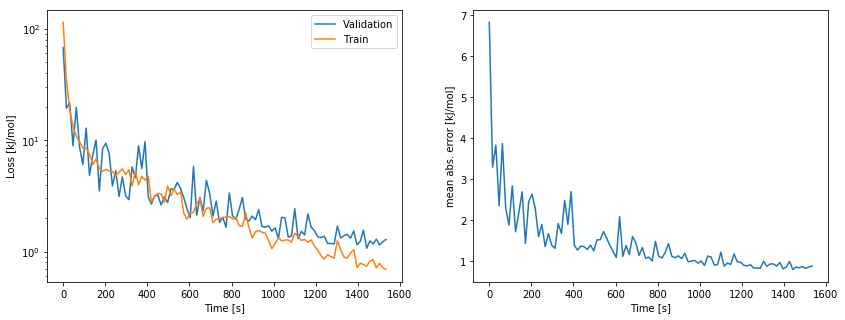

In [214]:
import numpy as np
import matplotlib.pyplot as plt
from ase.units import kJ, mol

results = np.loadtxt('log.csv', skiprows=1, delimiter=',')

time = results[:,0]-results[0,0]
learning_rate = results[:,1]
train_loss = results[:,2]
val_loss = results[:,3]
val_mae = results[:,4]

print('Final validation MAE:', np.round(val_mae[-1], 2), 'kJ/mol')

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(time, val_loss, label='Validation')
plt.plot(time, train_loss, label='Train')
plt.yscale('log')
plt.ylabel('Loss [kJ/mol]')
plt.xlabel('Time [s]')
plt.legend()
plt.subplot(1,2,2)
plt.plot(time, val_mae)
plt.ylabel('mean abs. error [kJ/mol]')
plt.xlabel('Time [s]')
plt.savefig('error.pdf', bbox_inches='tight')
plt.show()

In [215]:
csv = pd.read_csv('log.csv')
csv

,Time,Learning rate,Train loss,Validation loss,MAE_energy
0,15.690511,0.010000,114.106714,67.769316,6.823444
1,31.284052,0.010000,34.435585,19.369038,3.290628
2,46.897220,0.010000,18.577134,21.601597,3.831089
3,62.492607,0.010000,13.266411,8.881129,2.351430
4,78.073085,0.010000,10.832147,19.707671,3.867418
5,93.681171,0.010000,9.637781,8.651816,2.300346
6,109.367753,0.010000,8.514488,6.055081,1.879948
7,125.018615,0.010000,8.483257,12.833254,2.841944
8,140.654514,0.010000,7.477512,4.832167,1.718640
9,156.298088,0.010000,6.041571,7.333639,2.189678


In [218]:
dir(model)

['__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_apply',
 '_backend',
 '_backward_hooks',
 '_buffers',
 '_forward_hooks',
 '_forward_pre_hooks',
 '_get_name',
 '_load_from_state_dict',
 '_load_state_dict_pre_hooks',
 '_modules',
 '_named_members',
 '_parameters',
 '_register_load_state_dict_pre_hook',
 '_register_state_dict_hook',
 '_slow_forward',
 '_state_dict_hooks',
 '_tracing_name',
 '_version',
 'add_module',
 'apply',
 'buffers',
 'children',
 'cpu',
 'cuda',
 'double',
 'dump_patches',
 'eval',
 'extra_repr',
 'float',
 'forward',
 'half',
 'load_state_dict',
 'modules',
 'named_buffers',
 'named_